# Which COVID-19 Vaccine is Best for You?
## DS4A Team 55 Preliminary EDA


In [1]:
import pandas as pd
import numpy as np
import math
import base64
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

### state_vax.csv
Vaccine administration data for states within the U.S., including the District of Columbia from 12/13/2020 to the present, updated daily. 

In [2]:
client = Socrata(
        domain = "data.cdc.gov",
        app_token = "bsYMLkKAQhIIVd7wzBzp5BiCR",
        timeout=10
        )
results = client.get_all("unsk-b7fc")

# convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df.sample(10)

,date,mmwr_week,location,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_unk_manuf,dist_per_100k,distributed_per_100k_12plus,...,administered_dose1_recip_5pluspop_pct,series_complete_5plus,series_complete_5pluspop_pct,administered_5plus,admin_per_100k_5plus,distributed_per_100k_5plus,series_complete_moderna_5plus,series_complete_pfizer_5plus,series_complete_janssen_5plus,series_complete_unk_manuf_5plus
22381,2021-01-27T00:00:00.000,4,OH,1507000,0,0,0,0,12892,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
22214,2021-01-30T00:00:00.000,4,MS,425000,0,0,0,0,14280,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
7551,2021-09-12T00:00:00.000,37,UT,3883720,172400,1493720,2217600,0,121141,149820,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
18895,2021-03-22T00:00:00.000,12,DE,486095,12300,227900,245895,0,49919,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
14313,2021-05-31T00:00:00.000,22,IH2,1733425,74200,915300,743925,0,83225,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1188,2021-12-20T00:00:00.000,51,ME,2842970,150500,1101260,1591210,0,211497,239926,...,88.9,1009373,78.8,2426627,189480,221990,369597,511781,127485,510
5399,2021-10-15T00:00:00.000,41,VA,13241155,593200,4944900,7703055,0,155130,181213,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
8864,2021-08-23T00:00:00.000,34,MH,51300,10800,40500,0,0,87823,102839,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
11100,2021-07-20T00:00:00.000,29,CO,7144625,340300,2932900,3871425,0,124066,144743,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
23952,2021-01-03T00:00:00.000,1,AK,54975,0,0,0,0,7515,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [3]:
# df.info()

In [4]:
# remove all distribution cols
# remove "Administered", this is the total for 1st dose and complete series
# remove all 5plus cols, very recently approved and sporadic across states
# remove additional doses for 50plus, age group doesn't show up elsewhere in dataset


df = df.drop(columns= ["mmwr_week","distributed", "distributed_janssen", "distributed_moderna", 
                       "distributed_pfizer", "distributed_unk_manuf", "dist_per_100k","distributed_per_100k_12plus",
                       "distributed_per_100k_18plus", "distributed_per_100k_65plus", "distributed_per_100k_5plus",
                       "administered","administered_dose1_recip_5plus",
                       "administered_dose1_recip_5pluspop_pct", "series_complete_5plus", "series_complete_5pluspop_pct", 
                       "administered_5plus", "admin_per_100k_5plus", "series_complete_moderna_5plus",
                       "series_complete_pfizer_5plus", "series_complete_janssen_5plus", "series_complete_unk_manuf_5plus",
                       "additional_doses_50plus", "additional_doses_50plus_vax_pct"], axis=1)

In [5]:
# removing locations outside of the contential united states as well as united states total

drop_location = ["AS", "BP2", "DD2", "FM", "GU",
                 "IH2", "MH", "MP", "PR", "RP",
                 "US", "VA2", "VI", "LTC"]
df = df[~df["location"].isin(drop_location)]

# checking that location vals = 51, including DC

df.location.nunique()

51

In [6]:
# abbreviating column names for readability
# cols in api data are labelled differently than csv directly from data.cdc.gov, values match up so renaming those cols

rename_cols = {"administered_12plus":"admin_12plus", 
               "administered_18plus":"admin_18plus",
               "administered_65plus":"admin_65plus",
               "administered_janssen":"admin_janssen",
               "administered_moderna":"admin_moderna",
               "administered_pfizer":"admin_pfizer",
               "administered_unk_manuf":"admin_unk",
               "recip_administered":"recip_admin",
               "administered_dose1_recip":"admin_dose1",
               "administered_dose1_pop_pct":"admin_dose1_pop_pct",
               "administered_dose1_recip_1":"admin_dose1_12plus",
               "administered_dose1_recip_2":"admin_dose1_12plus_pop_pct",
               "administered_dose1_recip_3":"admin_dose1_18plus",
               "administered_dose1_recip_4":"admin_dose1_18plus_pop_pct",
               "administered_dose1_recip_5":"admin_dose1_65plus",
               "administered_dose1_recip_6":"admin_dose1_65plus_pop_pct",
               "series_complete_yes":"series_complete",
               "series_complete_12pluspop":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop":"series_complete_65plus_pop_pct",
               "series_complete_unk_manuf":"series_complete_unk",
               "series_complete_unk_manuf_1":"series_complete_unk_12plus",
               "series_complete_unk_manuf_2":"series_complete_unk_18plus",
               "series_complete_unk_manuf_3":"series_complete_unk_65plus",
               "series_complete_12pluspop_pct":"series_complete_12plus_pop_pct",
               "series_complete_18pluspop_pct":"series_complete_18plus_pop_pct",
               "series_complete_65pluspop_pct":"series_complete_65plus_pop_pct"
               }
df = df.rename(columns=rename_cols)

In [7]:
# df.columns

In [8]:
# see data types of df
# all types = object, need to change to ints and floats
# df.dtypes

In [9]:
# show cols with NaNs
# cols with NaNs are additional dose cols, after investigating this happens when other additional dose cols are 0
df.columns[df.isnull().any()]

Index(['additional_doses', 'additional_doses_vax_pct',
       'additional_doses_18plus', 'additional_doses_18plus_vax_pct',
       'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
       'additional_doses_moderna', 'additional_doses_pfizer',
       'additional_doses_janssen', 'additional_doses_unk_manuf'],
      dtype='object')

In [10]:
# replace NaNs with 0 to fill in values
nan_col = ['additional_doses', 'additional_doses_vax_pct',
           'additional_doses_18plus', 'additional_doses_18plus_vax_pct',
           'additional_doses_65plus', 'additional_doses_65plus_vax_pct',
           'additional_doses_moderna', 'additional_doses_pfizer',
           'additional_doses_janssen', 'additional_doses_unk_manuf']
df[nan_col] = df[nan_col].fillna(0)

In [11]:
to_int = ['admin_12plus', 'admin_18plus', 'admin_65plus','admin_janssen',
          'admin_moderna', 'admin_pfizer', 'admin_unk','admin_per_100k',
          'admin_per_100k_12plus', 'admin_per_100k_18plus','admin_per_100k_65plus',
          'recip_admin', 'admin_dose1', 'admin_dose1_12plus', 'admin_dose1_18plus',
          'admin_dose1_65plus', 'series_complete_12plus', 'series_complete_18plus',
          'series_complete','series_complete_65plus', 'series_complete_janssen', 'series_complete_moderna',
          'series_complete_pfizer','series_complete_unk', 'series_complete_janssen_12plus',
          'series_complete_moderna_12plus', 'series_complete_pfizer_12plus', 'series_complete_unk_12plus',
          'series_complete_janssen_18plus', 'series_complete_moderna_18plus', 'series_complete_pfizer_18plus',
          'series_complete_unk_18plus', 'series_complete_janssen_65plus', 'series_complete_moderna_65plus',
          'series_complete_pfizer_65plus', 'series_complete_unk_65plus', 'additional_doses',
          'additional_doses_18plus', 'additional_doses_65plus', 'additional_doses_moderna',
          'additional_doses_pfizer', 'additional_doses_janssen', 'additional_doses_unk_manuf'
         ]

to_float = ['admin_dose1_pop_pct', 'admin_dose1_12plus_pop_pct', 'admin_dose1_18plus_pop_pct',
            'admin_dose1_65plus_pop_pct', 'series_complete_pop_pct', 'series_complete_12plus_pop_pct',
            'series_complete_12plus_pop_pct', 'series_complete_18plus_pop_pct', 'series_complete_65plus_pop_pct',
            'additional_doses_vax_pct', 'additional_doses_18plus_vax_pct', 'additional_doses_65plus_vax_pct'
           ]

df[to_int] = df[to_int].astype("int")
df[to_float] = df[to_float].astype("float")

In [12]:
# checking that data types hace been converted correctly
# df.dtypes

In [14]:
# converting "date" col to datetime
df["date"] = pd.to_datetime(df["date"])

In [15]:
# filter location to New York
df_ny = df.loc[df["location"] == "NY"]

In [16]:
# set index to date to extract rows for the first of each month, aligns with how other datasets are reported
df_ny_m = df_ny.set_index("date")
df_ny_m = df_ny_m.groupby(df_ny_m.index.strftime("%Y-%m")).tail(1)
df_ny_m.head(10)

,location,admin_12plus,admin_18plus,admin_65plus,admin_janssen,admin_moderna,admin_pfizer,admin_unk,admin_per_100k,admin_per_100k_12plus,...,additional_doses,additional_doses_vax_pct,additional_doses_18plus,additional_doses_18plus_vax_pct,additional_doses_65plus,additional_doses_65plus_vax_pct,additional_doses_moderna,additional_doses_pfizer,additional_doses_janssen,additional_doses_unk_manuf
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,NY,33729902,31773550,7970310,1348370,12653266,20488081,15751,177374,201094,...,4686613,33.5,4648178,36.3,1719843,58.7,2082738,2522950,80678,247
2021-12-01,NY,29780989,27946653,7038182,1245561,11046085,17722694,11816,154348,177551,...,2053051,15.4,2051249,16.5,992302,34.6,876774,1149165,27072,40
2021-11-01,NY,27672902,25904827,6358360,1179846,10090429,16394605,10689,142265,164983,...,785287,6.0,784264,6.5,469195,16.6,187754,593410,4102,21
2021-10-01,NY,25961184,24306764,5831882,1127289,9695417,15131586,9364,133465,154778,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-09-01,NY,24426700,22985019,5633411,1072305,9356997,13991672,7909,125575,145629,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-08-01,NY,22995942,21813875,5488352,1013560,9040360,12937436,6485,118219,137099,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-07-01,NY,21849369,20873295,5370845,948791,8743524,12153595,5114,112324,130263,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-06-01,NY,19706068,19188844,5168904,828036,8151594,10723586,4162,101305,117485,...,0,0.0,0,0.0,0,0.0,0,0,0,0
2021-05-01,NY,0,15705472,4733041,603095,6819234,8433328,2942,81520,0,...,0,0.0,0,0.0,0,0.0,0,0,0,0


In [17]:
# first reported date and most recent date for vax data, updated daily
print(df_ny["date"].min())
print(df_ny["date"].max())

2020-12-14 00:00:00
2022-01-07 00:00:00


<AxesSubplot:title={'center':'Rates of COVID-19 by Manufacturer'}, xlabel='date'>

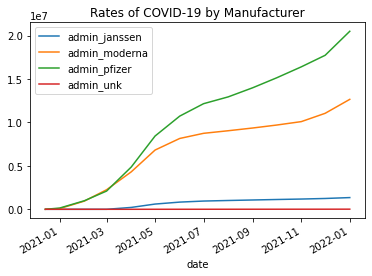

In [30]:
# trend in administration of each vax manufacturer 
ny_m_plt = df_ny_m.reset_index()
ny_m_plt.plot(x="date", y=["admin_janssen", "admin_moderna", "admin_pfizer", "admin_unk"], kind="line", title="Rates of COVID-19 by Manufacturer")

In [32]:
# shows the J&J admin rate in more detail compared to Moderna, since Moderna's rate is nearer to J&Js
# ny_m_plt.plot(x="date", y=["admin_janssen", "admin_moderna"])

In the "Rates of COVID-19 Vaccine Administration by Manufacturer" graph, above, Pfizer and Moderna are the most administered vaccines with Pfizer being the highest. Rates of J&J and vaccines by an unknown manufacturer are very low compared to Pfizer and Moderna. The J&J vaccine has a steady and slow upwards trend as the year progreses.

---

<AxesSubplot:title={'center':'Rate of COVID-19 Vaccine Administration by Manufacturer'}, xlabel='date'>

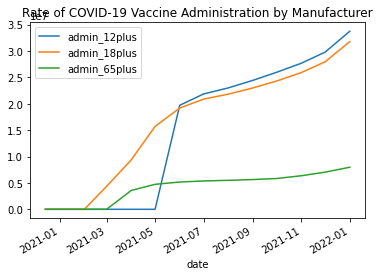

In [31]:
# 
ny_m_plt.plot(x="date", y=["admin_12plus", "admin_18plus", "admin_65plus"], kind="line", title="Rate of COVID-19 Vaccine Administration by Age Group")

In the "Rates of COVID-19 Vaccine Administration by Age Group" graph, above, age group 18plus is the most vaccinated until 12plus spikes in May of 2021 and passes 18plus shortly after. Age group 65plus remains the lowest with a sharp increase in March of 2021 and has been steadily increasing since then. However, this graph only tells part of the story. We should look into the percent of population per each age group to get a better understanding of vaccination trends.

---

<AxesSubplot:title={'center':'Rates of COVID-19 Vaccine Administration by 100k per Age Group'}, xlabel='date'>

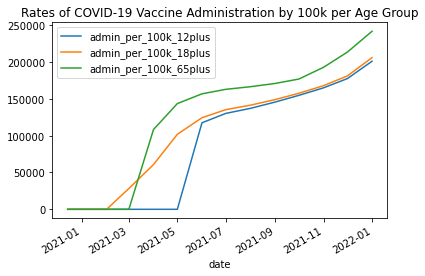

In [33]:
# trend in administration of vaccine by manufacturer
ny_m_plt.plot(x="date", y=["admin_per_100k_12plus", "admin_per_100k_18plus", "admin_per_100k_65plus"], kind="line", title="Rates of COVID-19 Vaccine Administration by 100k per Age Group")

Comparing the "Rates of COVID-19 Vaccine Administration by 100k per Age Group" graph to the graph showing only the value counts for each age group reveals new insights. In the per 100k graph, the 65plus age group remains the highest vaccinated group by a good margin throughout the reported timeframe. Once people 12plus were able to get vaccinated in May 2021 the rate of vaccination for this group rose almost immediately and lies just below the rate of the 18plus group.

---

<AxesSubplot:xlabel='date'>

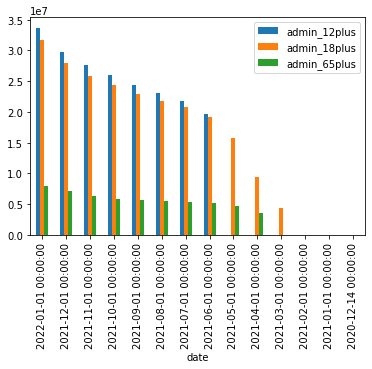

In [24]:
ny_m_plt.plot.bar(x="date", y=["admin_12plus", "admin_18plus", "admin_65plus"])

### covid_cases

### census_data

### percent_vaccinated_race & percent_cases_race

### vaers